
<div style="text-align: center; line-height: 0; padding-top: 9px;">
  <img src="https://databricks.com/wp-content/uploads/2018/03/db-academy-rgb-1200px.png" alt="Databricks Learning">
</div>



## Classroom Setup

Before starting the demo, run the provided classroom setup script. This script will define configuration variables necessary for the demo. Execute the following cell:

In [0]:
%pip install -U -qq databricks-sdk databricks-vectorsearch langchain-databricks langchain==0.3.7 langchain-community==0.3.7

dbutils.library.restartPython()

# **A Beginner’s Guide to LangChain’s Pre-LCEL Workflow**  

## **Introduction**  
Before LangChain Expression Language (LCEL) was introduced in late 2023 (version 0.1.0), building AI-powered document workflows required stitching together multiple components manually. This guide explains how LangChain worked in its early days, focusing on three key phases:  

1. **Document Ingestion (Indexing)** – Loading and preparing documents for search  
2. **Retrieval** – Finding relevant text chunks based on a user’s question  
3. **Generation** – Producing an answer using an LLM  

The Proliferation of Chains - A RAG Workflow Example
To better understand the "straitjacket" feeling and the proliferation of chains, let's consider a common application: a simple Retrieval Augmented Generation (RAG) workflow designed to answer user queries based on content extracted from a PDF file. This seemingly straightforward task, when implemented with older LangChain, clearly demonstrated the architectural challenges.

A typical RAG workflow can be broken down into three distinct conceptual pipelines:

1. Document Ingestion Pipeline (Indexing): This initial stage involves ingesting the PDF document, splitting it into manageable chunks, creating embeddings for these chunks, and storing them in a vector database.

2. Retrieval Pipeline: When a user poses a query, this pipeline is responsible for searching the vector database to find the most relevant document chunks (context) that pertain to the query.

3. Generation Pipeline: Finally, the retrieved context and the user's original query are fed into a Large Language Model (LLM) to generate a coherent and accurate answer.

## **1. Document Ingestion**  
Before LangChain could answer questions, it needed a way to store and search documents. Here’s how it worked:  

### **Step-by-Step Process**  
1. **Loading the Document**  
   - A tool like `PyPDFLoader` extracted raw text from a PDF.  
   - *Output*: A long string of unstructured text.  

2. **Splitting the Text**  
   - The `RecursiveCharacterTextSplitter` broke the text into smaller chunks (e.g., 500 characters each).  
   - *Why?* LLMs have limited context windows, so we feed them small, relevant sections.  

3. **Creating Embeddings**  
   - An embedding model (like OpenAI’s `text-embedding-ada-002`) converted each chunk into a numerical vector.  
   - *Key Idea*: Similar texts have similar vectors, enabling semantic search.  

4. **Storing in a Vector Database**  
   - A database like **Chroma** or **FAISS** stored these vectors for fast retrieval.  
   - *Result*: A searchable knowledge base.  

### **Was This a "Chain"?**  
Technically, yes! While early LangChain didn’t enforce a strict `Chain` class for ingestion, developers often used:  
- `SequentialChain` (to run steps in order)  
- `VectorstoreIndexCreator` (a helper that automated the process)  

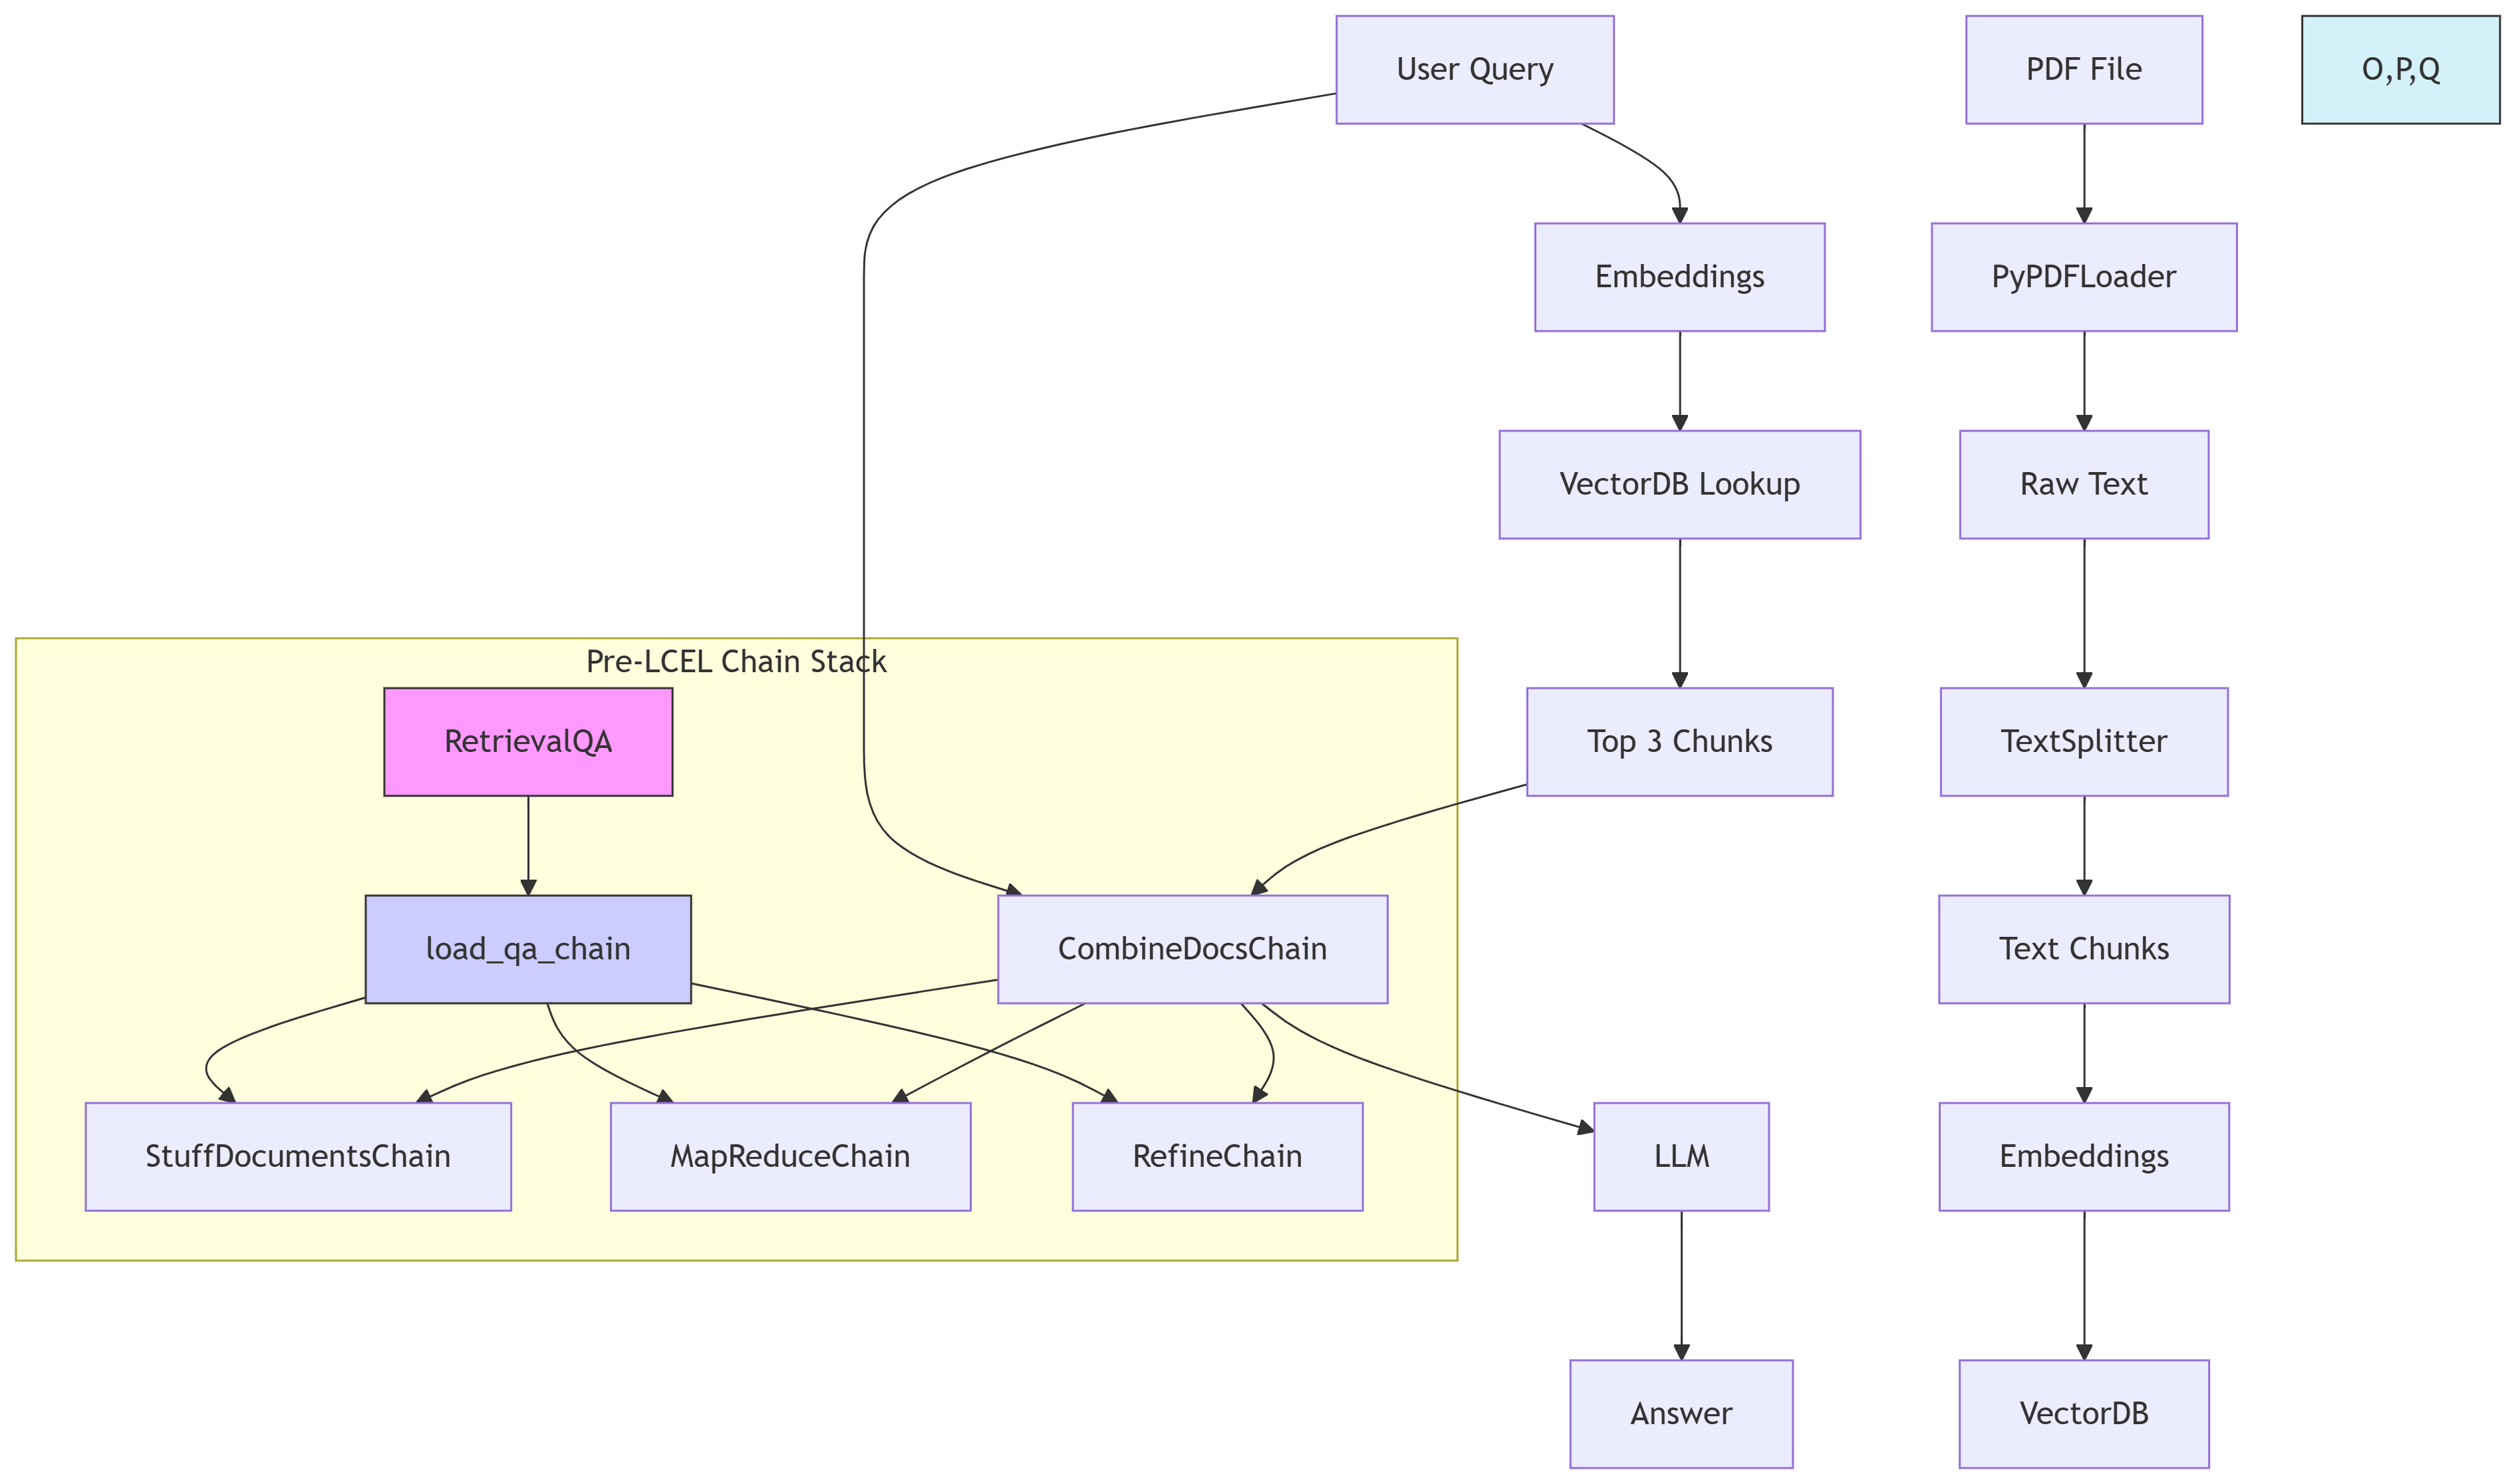

## **2. Retrieval**  
When a user asked a question, LangChain:  

1. **Embedded the Query**  
   - The same embedding model converted the question into a vector.  

2. **Searched the Vector Database**  
   - The system found the top-k (usually top-3) most similar text chunks (by comparing vectors).  
   - *Why top-3?* More chunks = better context, but too many can overwhelm the LLM.  



## **3. Generation**  
This is where pre-LCEL LangChain got complicated. Instead of a single step, it required stacking multiple "chains" (See example here: https://python.langchain.com/v0.1/docs/use_cases/summarization/#option-1-stuff):  

### **The Chain Stack**  
1. **`RetrievalQA` Chain**  
   - The main interface for Q&A.  
   - *Internally*, it used:  

2. **`load_qa_chain`**  
   - A helper that managed how documents were fed to the LLM.  
   - *Three variants existed*:  
     - **`StuffDocumentsChain`** (dump all chunks into the prompt)  
     - **`MapReduceChain`** (process chunks separately, then combine)  
     - **`RefineChain`** (iteratively improve the answer)  

3. **`CombineDocsChain`**  
   - The base class handling document merging before sending to the LLM.  

4. **LLM + Output Parser**  
   - The final step where the LLM (e.g., GPT-3) generated an answer.  

Here's what this workflow looked like in code:

```python

from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA, load_qa_chain
from langchain.llms import OpenAI

# ========================
# 1. Document Ingestion (Manual Chain)
# ========================
loader = PyPDFLoader("example.pdf")
raw_documents = loader.load()

# Split documents into chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50
)
documents = text_splitter.split_documents(raw_documents)

# Create vectorstore manually
embeddings = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(documents, embeddings)

# ========================
# 2. Configure RetrievalQA 
# ========================
# Define which document chain to use 
chain_type = "stuff"  # Could be also be "map_reduce" or "refine" as seen in the diagram

# Load the QA chain (internally uses StuffDocumentsChain/MapReduceChain/RefineChain)
qa_chain = load_qa_chain(
    llm=OpenAI(temperature=0),
    chain_type=chain_type 
)

# Wrap in RetrievalQA
qa = RetrievalQA(
    combine_documents_chain=qa_chain,
    retriever=vectorstore.as_retriever()
)

# ========================
# 3. Run a query
# ========================
query = "What is the main topic of this document?"
result = qa.run(query)
print(result)

```

### **Why Was This Cumbersome?**  
- Developers had to manually choose and initialize chains.  
- Small changes (e.g., switching from `stuff` to `map_reduce`) required rewriting code.  
- No built-in streaming or async support without extra work.  

From the above, you see that you could easily have maybe five or six different chains, depending on your workload. This was a poor design choice. Every task needed its own specific kind of chains and this was not sustainable. On many occasions, it is possible to encounter a task that did not a have a chain class in LangChain. This felt like being put in a straitjacket.

This approach led to a situation where a developer needed to be intimately familiar with a multitude of specific chain classes and helper functions: RetrievalQA, load_qa_chain, create_stuff_documents_chain, MapReduceDocumentsChain, StuffDocumentsChain, and so on. Each chain was designed for a particular sub-task, and combining them into a complete application often felt like assembling a complex puzzle where the pieces didn't always fit seamlessly. The lack of a unified, flexible interface for composing these disparate components was a significant hurdle, making it challenging to build custom workflows or easily swap out components without refactoring large portions of the application logic.


# **Langchain is reborn (v0.1) - From Chains to Runnables**


To make things a bit more dynamic, Langchain introduced the concept of runnables. Instead of having chains and regimented chain classes, LangChain decided to free devs to choose the way they implemented the unique components of their workflow. The only thing required was that each of these unique components were to be Runnables. A Runnable is a python object that implements four key methods: `invoke`, `batch`, `stream` and `astream_events` (see https://python.langchain.com/docs/concepts/runnables/). This paradigm was etched into Langchain v0.2 and above and is known as Langchain Expression Language (LCEL) (See https://python.langchain.com/docs/concepts/lcel/). The highlight of LCEL is that devs are allowed to create any objects that they want as part of their chain, as long as they are runnables. 
Instead of the old chain method, we have LCEL composables that look like this:
`lcel_chain = prompt | model | output_parser`


There are three main components in the new Langchain:

1. Model
2. Prompt Templates (ChatPromptTemplate (for multi-turn conversations), and PromptTemplate (for single-turn interactions)
3. StrOutputParser


Let's see how to implement each of the above components as runnables. 
1. Models: Models in Langchain are implemented using the respective class that belongs to the model's provider (e.g. ChatDatabricks or ChatOpenAI). These classes are runnables because they implement the methods above)
2. The output parser is also implemented as a runnable using the StrOutputParser class (or any other output parser, depending on the use case).
3. The prompt template is the most technical part of the chain to implement. This is because this is where most of the logic that the Langchain app requires to work is declared. In the next section, we'll see prompt templates and how they are created in LCEL.

In [0]:
import os
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate # This turns the prompt into a Runnable
from langchain_databricks import ChatDatabricks


# Instantiate the model and parser
model = ChatDatabricks(endpoint="databricks-meta-llama-3-3-70b-instruct", max_tokens=1000)

output_parser = StrOutputParser()

# Prompt: The Place it all begins

Your prompt determines what your chain (composables) look like. There are three possibilities
1. A simple prompt without placeholders (not too common in production because the user's intent is not known before hand)
2. A simple prompt with one placeholder
3. A simple prompt with many placeholders

In [0]:
# Example 1 - A simple prompt without placeholder
from langchain_core.prompts import ChatPromptTemplate


fixed_prompt = ChatPromptTemplate.from_template(
    "Summarize the key principles of quantum physics in three sentences."
)
chain = fixed_prompt | model | output_parser
# Invocation requires no specific input variables
result = chain.invoke({})
print(result)

In [0]:
# Example 2 - A prompt with a placeholder
from langchain_core.prompts import ChatPromptTemplate

single_placeholder_prompt = ChatPromptTemplate.from_template(
    "Explain the main benefits of using {technology} for data analysis."
)
chain = single_placeholder_prompt | model | output_parser

# Invocation requires a dictionary with the 'technology' key
result = chain.invoke({"technology": "Power BI"})
print(result)

In [0]:
# Example 3 - A prompt with multiple placeholders
from langchain_core.runnables import RunnableParallel, RunnablePassthrough

# A python function that mimics our vector database output

context = ['Databricks Lakehouse Platform is a cloud-based data management and analytics platform that combines the best of data warehouses and data lakes to provide a unified, open, and scalable architecture for data-driven organizations. By integrating data engineering, data science, and business analytics into a single platform, Databricks enables users to ingest, process, and analyze large volumes of data from various sources, and then use that data to inform business decisions, drive innovation, and improve customer experiences. With its foundation in Apache Spark and Delta Lake, the Databricks Lakehouse Platform provides a fast, secure, and collaborative environment for data teams to work together, leveraging features such as data versioning, ACID transactions, and real-time data processing to unlock new insights and opportunities.']

def retriever(question):
    return context

multi_placeholder_prompt = ChatPromptTemplate.from_template(
    "Based on the following context:\n{context}\n\n give a summarized answer to this question: {question}"
)


# Example using RunnableParallel to gather inputs for the prompt
setup_and_prompt = {"context": retriever, "question": RunnablePassthrough()} | multi_placeholder_prompt

# # Example using RunnableParallel to gather inputs for the prompt
# setup_and_prompt = RunnableParallel(
#     {"context": retriever, "question": RunnablePassthrough()}
# ) | multi_placeholder_prompt

chain = setup_and_prompt | model | output_parser

# Invocation might start with just the question, the chain fetches context
result = chain.invoke({"question": "What is the lakehouse architecture?"})
print(result)

# Internally, RunnableParallel ensures the prompt receives {'context': '...', 'question': '...'}

## **The right way to build with LangChain**

This is my preferred workflow to prevent deprecation problems that LangChain is known for:

- All retrieval, database or special functions are implemented as regular python functions with the original libraries (e.g. if my retrieval involves a sqlite database, I use the `sqlite3` or `sqlalchemy` libraries). The functions will be passed as runnables using RunnableLambda

- LLM and Output Parsers will use Langchain's LLM and Output Parser classes as they are already runnables.

# **Understanding the various runnable classes**

1. RunnableLambda
2. RunnableParallel
3. RunnablePassthrough
4. RunnableMap
5. RunnableGenerator

### **1. RunnableLambda**
**Purpose**: Converts regular Python functions into LangChain executable components.  
**Key Points**:
- Acts as an adapter between Python functions and LangChain's pipeline system
- Input must be a single dictionary argument (LangChain's standard format)
- Output can be any Python object that downstream runnables can process
- Ideal for simple transformations or business logic within chains

**When to Use**: When you need to integrate existing Python functions into LangChain workflows.
Example: 

In [ ]:

from langchain_core.runnables import RunnableLambda

def add(data):
    return data.get('x') + data.get('y')

add_runnable = RunnableLambda(add)

add_runnable.invoke({"x": 1, "y": 2})  


Note that all inputs to these functions need to be a SINGLE argument. If you have a function that accepts multiple arguments, you should write a wrapper that accepts a single dict input and unpacks it into multiple arguments.

### **2. RunnableParallel**  
**Purpose**: Executes multiple runnables simultaneously and merges their results.  
**Key Points**:
- Takes a dictionary of named runnables (like a workflow fork)
- Maintains input structure while adding parallel outputs
- Output is a dictionary combining all results
- Essential for building complex, multi-branch workflows

**When to Use**: When you need to:
- Process different aspects of input simultaneously
- Combine multiple chain outputs
- Implement fan-out/fan-in patterns 

Note that all inputs to these functions need to be a SINGLE argument. If you have a function that accepts multiple arguments, you should write a wrapper that accepts a single dict input and unpacks it into multiple arguments.


In [ ]:
from langchain_core.runnables import RunnableParallel

def add(data):
    return data.get('x') + data.get('y')

def multiply(data):
    return data.get('x') + data.get('y')

add_runnable = RunnableLambda(add)

multiply_runnable = RunnableLambda(multiply)

add_multiply_runnable = RunnableParallel({"add": add_runnable, "multiply": multiply_runnable})

add_multiply_runnable.invoke({"x": 2, "y": 3})


### **3. RunnablePassthrough**  
**Purpose**: Preserves input data unchanged during chain execution.  
**Key Points**:
- Acts as an identity function in pipelines
- Can be used to:
  - Forward original inputs to later stages
  - Maintain state through chains
  - Combine with other runnables via `RunnableParallel`
- Often paired with dictionary manipulation to add new fields

**When to Use**: When you need to:
- Preserve original input alongside processed data
- Implement branching logic without data modification
- Debug chains by inspecting intermediate values

In [ ]:
from langchain_core.runnables import RunnablePassthrough

passthrough_runnable = RunnablePassthrough()

passthrough_runnable.invoke({"x", "y"})

### **4. RunnableMap**

**Purpose**: This pattern, (which can also be achieved with **`RunnableParallel`**) in LangChain, lets you **create a dictionary of results** by applying different `Runnable` components to an input concurrently. Each runnable's output is assigned to a specific key in the final output dictionary.

**Key Points**:
* **Parallel Processing**: Executes multiple `Runnable`s simultaneously, with each result going to a designated output key.
* **Structured Output**: Organizes the outputs into a single dictionary, great for building new fields or preparing inputs for the next step.
* **Targeted Transformations**: Allows you to process and modify only specific parts of your input, leaving others untouched.
* **Seamless Chaining**: The resulting dictionary output is directly compatible with subsequent components in an LCEL chain.

**When to Use**: Use this when you need to:
* **Process different parts of your input in parallel** to create a structured output.
* **Generate multiple distinct results** from a single input (e.g., various calculations or data retrievals).
* **Prepare complex, structured inputs** for later steps in your chain.

In [ ]:
from langchain_core.runnables import RunnableMap, RunnableLambda

def add(data):
    return data.get('x') + data.get('y')

def multiply(data):
    return data.get('x') * data.get('y')

add_runnable = RunnableLambda(add)

multiply_runnable = RunnableLambda(multiply)

map_runnable = RunnableMap(add=add_runnable, multiply=multiply_runnable)
map_runnable.invoke({"x": 2, "y": 3})

### **5. RunnableGenerator**  
**Purpose**: Handles Python generator functions within LangChain pipelines.  
**Key Points**:
- Processes inputs as iterators (required for streaming support)
- Must `yield` dictionaries for proper chain compatibility
- Enables:
  - Progressive output generation
  - Natural streaming interfaces
  - Multi-step yielding within single operations
- Input is automatically converted to an iterator

**When to Use**: When you need to:
- Implement streaming responses
- Generate multiple outputs from single inputs
- Maintain low-latency processing
- Handle large payloads incrementally

In [ ]:
from langchain_core.runnables import RunnableGenerator

def add_generator(input_iter):
    # Input comes as an iterator - we need to consume it
    for data in input_iter:
        yield {"result": data["x"] + data["y"]}

# Create the runnable
generator_runnable = RunnableGenerator(add_generator)

# Usage:
result = generator_runnable.invoke({"x": 2, "y": 3, "z": 3})
print(result) 